In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
#plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
from numpy.fft import fft2

In [89]:
filter_bank2D = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/data')
filter_bank2D_J_L = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/J_L')
filter_bank2D_psi_index = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/psi_index')
filter_bank2D_phi_index = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/phi_index')

Figure 1

In [3]:
import matplotlib.colors as mcolors
colors = [(0.8,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,0.7,0,c) for c in np.linspace(0,1,100)]
cmapgreen = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colormaps = [cmapred,cmapblue,cmapgreen]

In [4]:
from scipy.ndimage import map_coordinates

In [170]:
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad

def drawCirc(ax,radius,centX,centY,angle_,theta2_,color_='black'):
    #========Line
    arc = Arc([centX,centY],radius,radius,angle=angle_,
          theta1=0,theta2=theta2_,color=color_) #capstyle='round',linestyle='-',lw=10
    ax.add_patch(arc)


    #========Create the arrow head
    endX=centX+(radius/2)*np.cos(rad(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(rad(theta2_+angle_))

    ax.add_patch(                    #Create triangle as arrow head
        RegularPolygon(
            (endX, endY),            # (x,y)
            3,                       # number of vertices
            radius/25,                # radius
            rad(angle_+theta2_),     # orientation
            color=color_
        )
    )
    #ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 
    # Make sure you keep the axes scaled or else arrow will distort

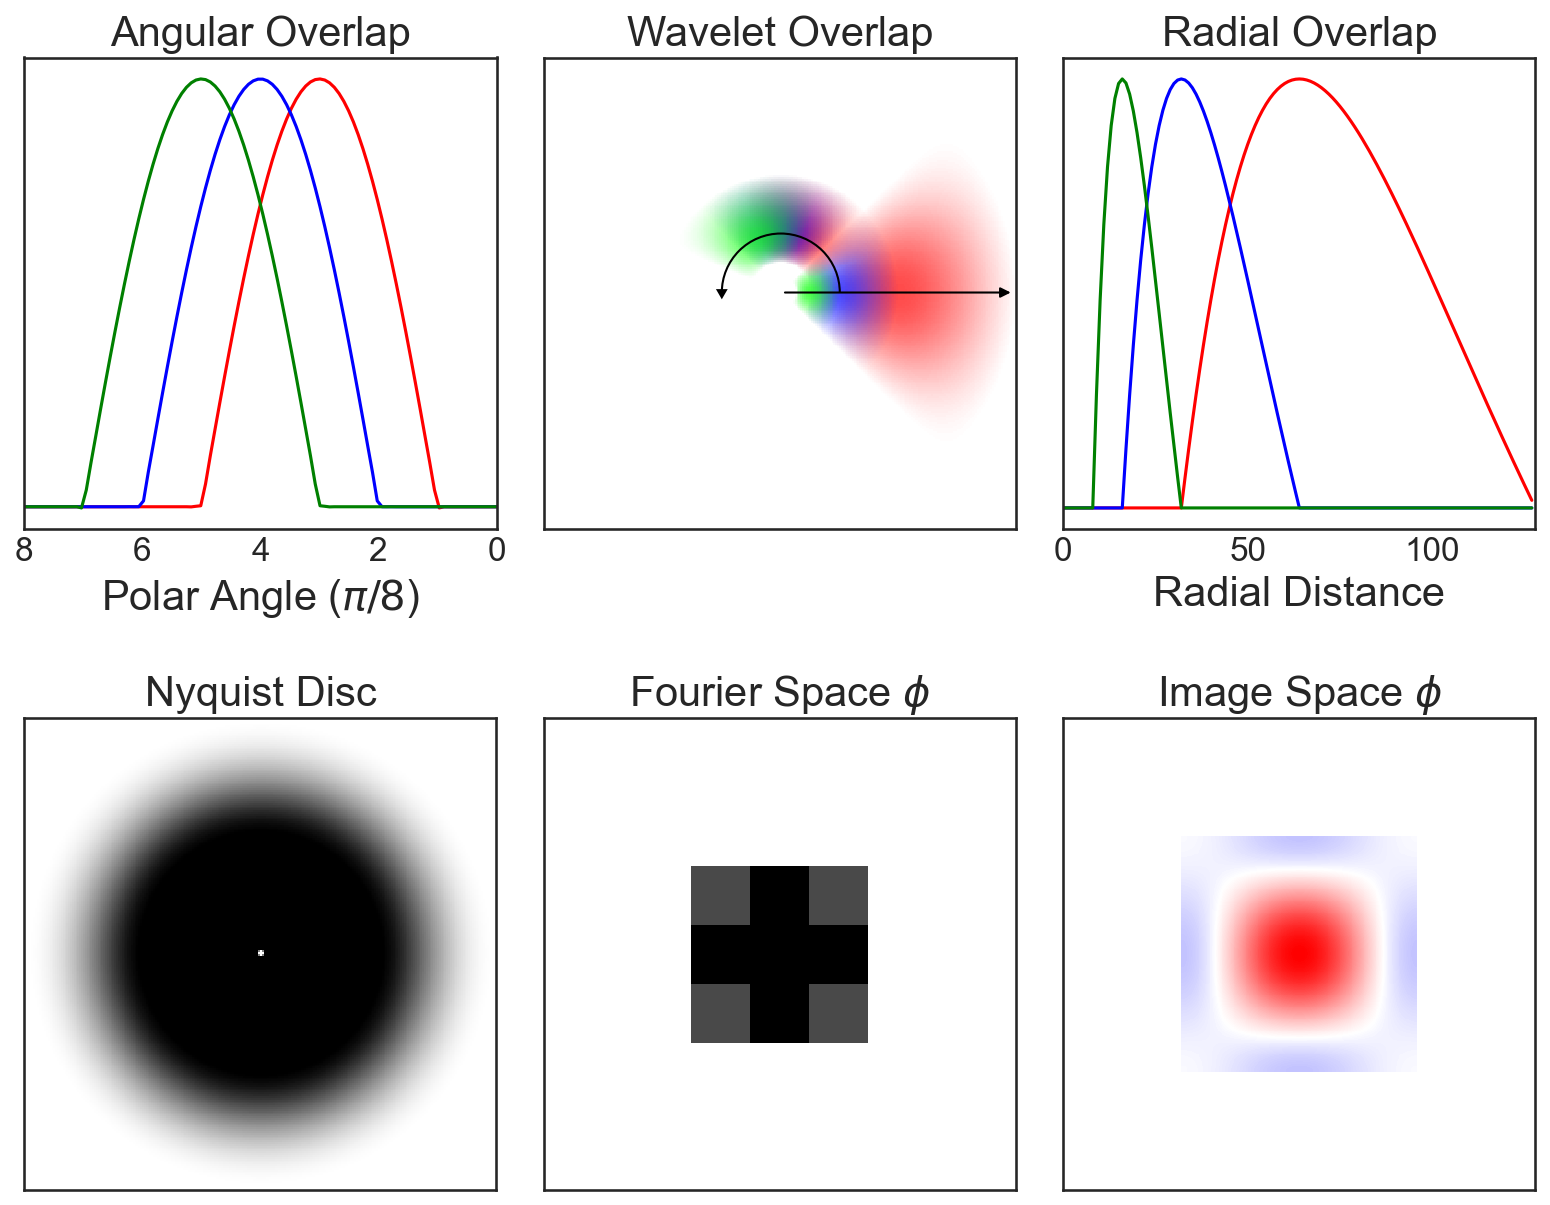

In [183]:
## Figure 1
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(13,10), dpi=150)

ax = fig.add_subplot(2,3,2)
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[jind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
ax.axes.set_title('Wavelet Overlap')

ax.annotate("",
            xy=(255, 128), xycoords='data',
            xytext=(128, 128), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3",
                            color='k'),
            )

drawCirc(ax,64,128,128,0,180)

colormaps = [cmapred,cmapblue,cmapgreen]
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[lind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,3)
color_opt = ['red','blue','green']
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    plt.plot(np.fft.fftshift(data).T[128,128:],color=color_opt[jind])
    ax.axes.yaxis.set_ticks([])
    ax.set_xlim(0,128)
ax.axes.set_xlabel('Radial Distance')
ax.axes.set_title('Radial Overlap')

ax = fig.add_subplot(2,3,1)
color_opt = ['red','blue','green']
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    data = np.fft.fftshift(data)
    
    t = np.linspace(np.pi,0,100)
    r = 32
    xc = 128
    yc = 128
    x = r*np.cos(t) + xc
    y = r*np.sin(t) + yc
    zi_fink = map_coordinates(data, np.vstack((x,y)))
    plt.plot(t/np.pi*8,zi_fink,color=color_opt[lind])
    ax.set_xlim(8, 0)
    ax.axes.yaxis.set_ticks([])
ax.axes.set_xlabel('Polar Angle ($\pi/8$)')
ax.axes.set_title('Angular Overlap')

ax = fig.add_subplot(2,3,4)
total_im_energy = np.zeros((256,256))
for j in range(6):
    for l in range(16):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1].T
        total_im_energy += np.fft.fftshift(data)**2

ax.imshow(
    total_im_energy,
    vmin=0,
    #vmax=1,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal',
    alpha=1
)
ax.axes.set_title('Nyquist Disc')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,5)

data = filter_bank2D[filter_bank2D_phi_index[0]-1].T
scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])

j=5
ax.imshow(
    np.fft.fftshift(data),
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.set_title('Fourier Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])

ax = fig.add_subplot(2,3,6)
ax.imshow(
    np.real(np.fft.fftshift(fft2(data)).T),
    vmin=-scale,
    vmax=scale,
    origin='lower',
    interpolation='nearest',
    cmap='bwr',
    aspect='equal'
)
ax.axes.set_title('Image Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])

fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.savefig('../figures/FinkletOrient.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

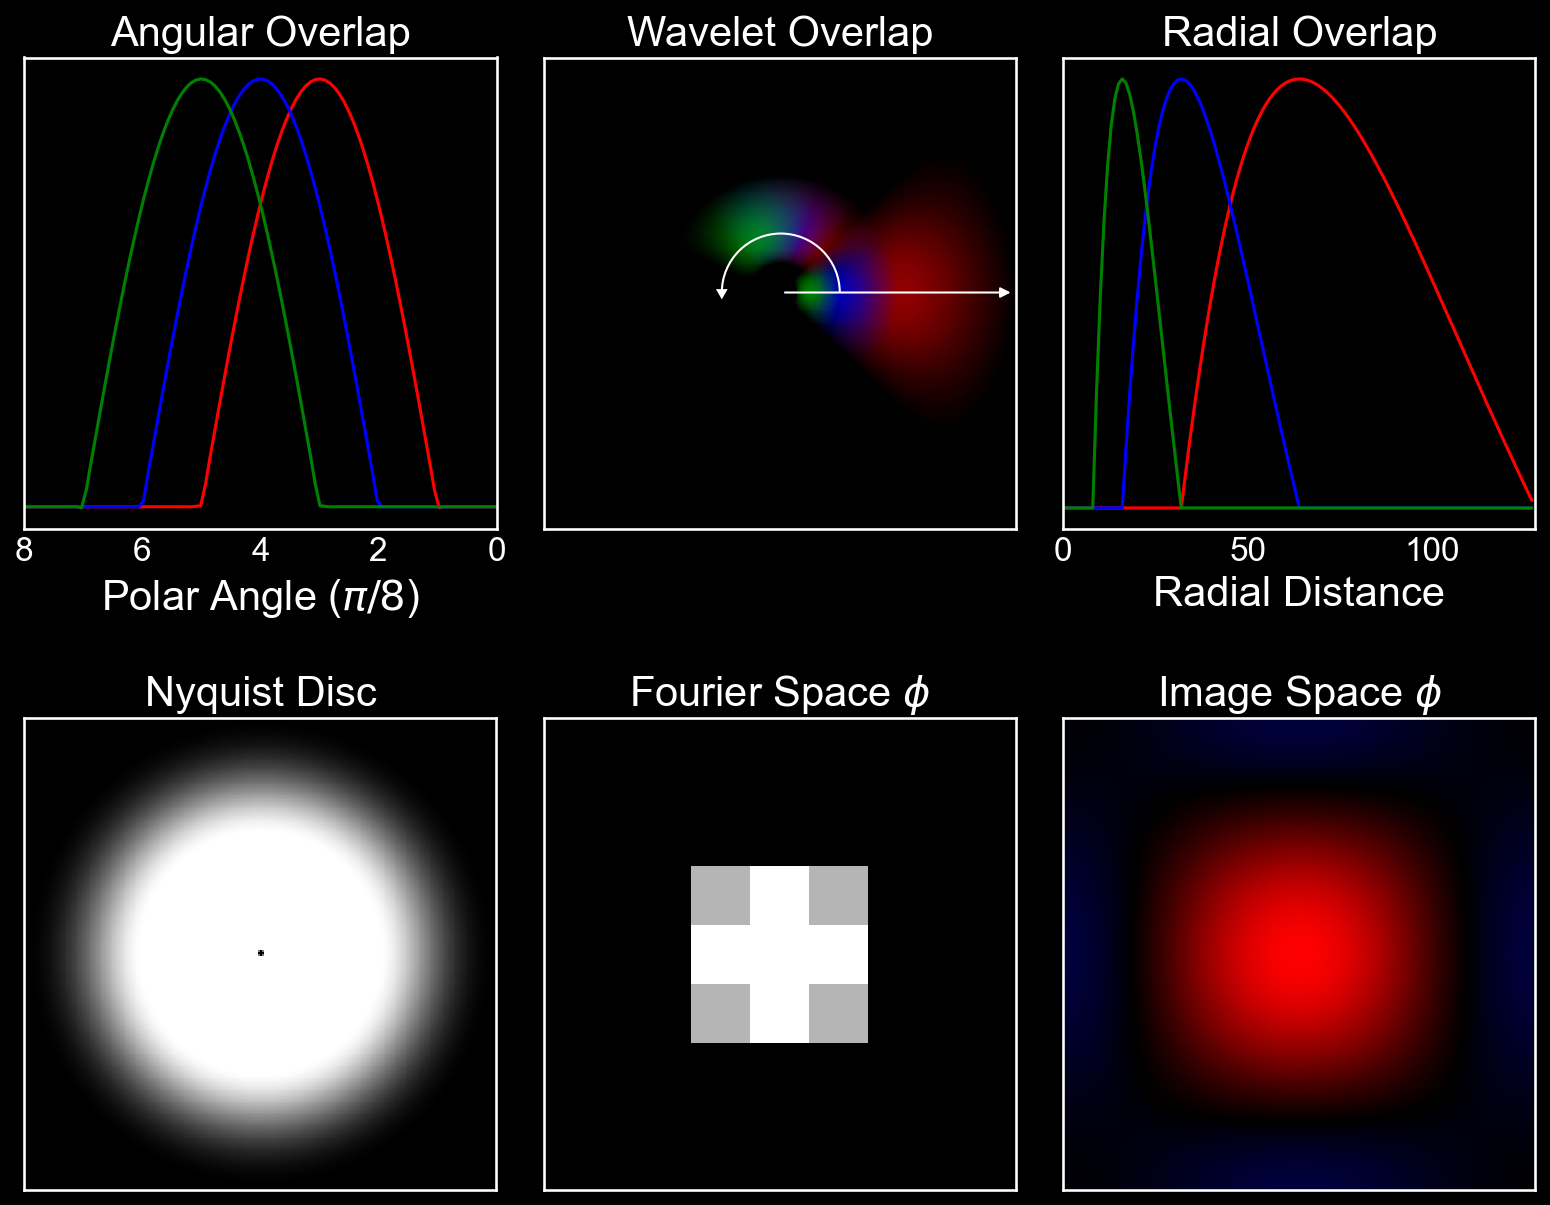

In [852]:
## Figure 1
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(13,10), dpi=150)

ax = fig.add_subplot(2,3,2)
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[jind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
ax.axes.set_title('Wavelet Overlap')

ax.annotate("",
            xy=(255, 128), xycoords='data',
            xytext=(128, 128), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3",
                            color='w'),
            )

drawCirc(ax,64,128,128,0,180,color_='w')

colormaps = [cmapred,cmapblue,cmapgreen]
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[lind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,3)
color_opt = ['red','blue','green']
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    plt.plot(np.fft.fftshift(data).T[128,128:],color=color_opt[jind])
    ax.axes.yaxis.set_ticks([])
    ax.set_xlim(0,128)
ax.axes.set_xlabel('Radial Distance')
ax.axes.set_title('Radial Overlap')

ax = fig.add_subplot(2,3,1)
color_opt = ['red','blue','green']
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    data = np.fft.fftshift(data)
    
    t = np.linspace(np.pi,0,100)
    r = 32
    xc = 128
    yc = 128
    x = r*np.cos(t) + xc
    y = r*np.sin(t) + yc
    zi_fink = map_coordinates(data, np.vstack((x,y)))
    plt.plot(t/np.pi*8,zi_fink,color=color_opt[lind])
    ax.set_xlim(8, 0)
    ax.axes.yaxis.set_ticks([])
ax.axes.set_xlabel('Polar Angle ($\pi/8$)')
ax.axes.set_title('Angular Overlap')

ax = fig.add_subplot(2,3,4)
total_im_energy = np.zeros((256,256))
for j in range(6):
    for l in range(16):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1].T
        total_im_energy += np.fft.fftshift(data)**2

ax.imshow(
    total_im_energy,
    vmin=0,
    #vmax=1,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal',
    alpha=1
)
ax.axes.set_title('Nyquist Disc')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,5)

data = filter_bank2D[filter_bank2D_phi_index[0]-1].T
scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])

j=5
ax.imshow(
    np.fft.fftshift(data),
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.set_title('Fourier Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])

ax = fig.add_subplot(2,3,6)
ax.imshow(
    np.real(np.fft.fftshift(fft2(data)).T),
    vmin=-scale,
    vmax=scale,
    origin='lower',
    interpolation='nearest',
    cmap=blue_red1,
    aspect='equal'
)
ax.axes.set_title('Image Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(np.abs(j+2)),128+2**(np.abs(j+2))])
ax.axes.set_ylim([128-2**(np.abs(j+2)),128+2**(np.abs(j+2))])

fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.savefig('../figures/FinkletOrientDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 2

In [920]:
def subplotter(data,fig,subplotx,subploty,subplotindx,j):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    ax.imshow(
        np.fft.fftshift(data).T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
    ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])
    ax.text(0.14, 0.05, 'FS j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])
    ax = fig.add_subplot(subplotx,subploty,subplotindx+8)
    ax.imshow(
        np.real(np.fft.fftshift(fft2(data)).T),
        vmin=-scale,
        vmax=scale,
        origin='lower',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Re j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    ax = fig.add_subplot(subplotx,subploty,subplotindx+16)
    ax.imshow(
        np.imag(np.fft.fftshift(fft2(data)).T),
        origin='lower',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Im j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)
    return

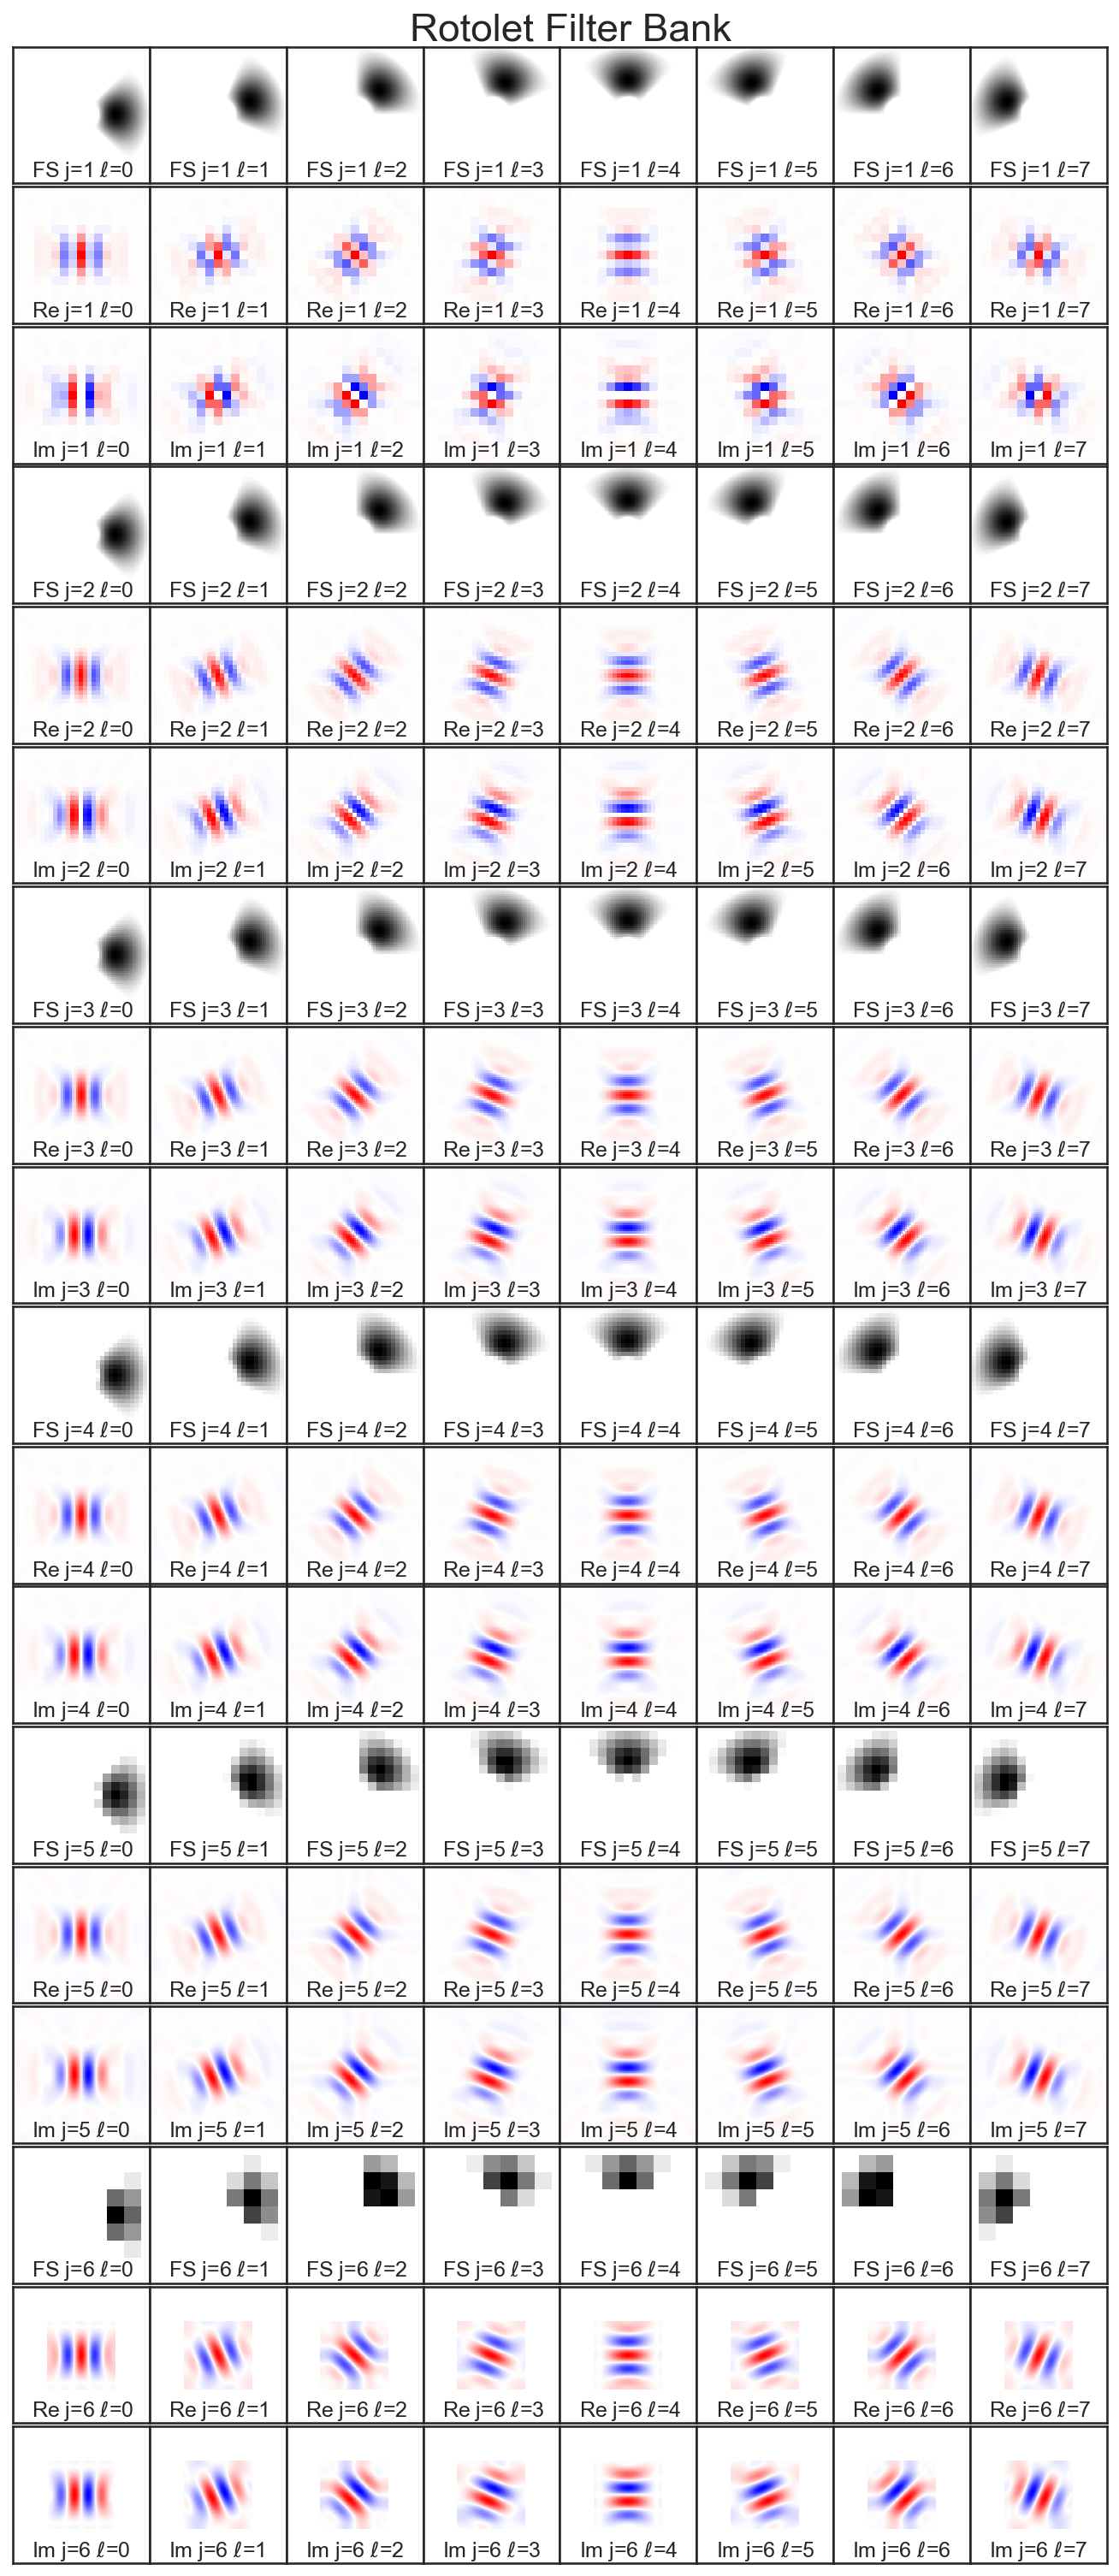

In [921]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(11,25.5), dpi=150)
for j in range(6):
    for l in range(8):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
        subplotter(data,fig,6*3,8,j*8*3+l+1,j)

plt.suptitle('Rotolet Filter Bank',size=22,x=0.52,y=0.89)
fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('../figures/FinkletBank.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

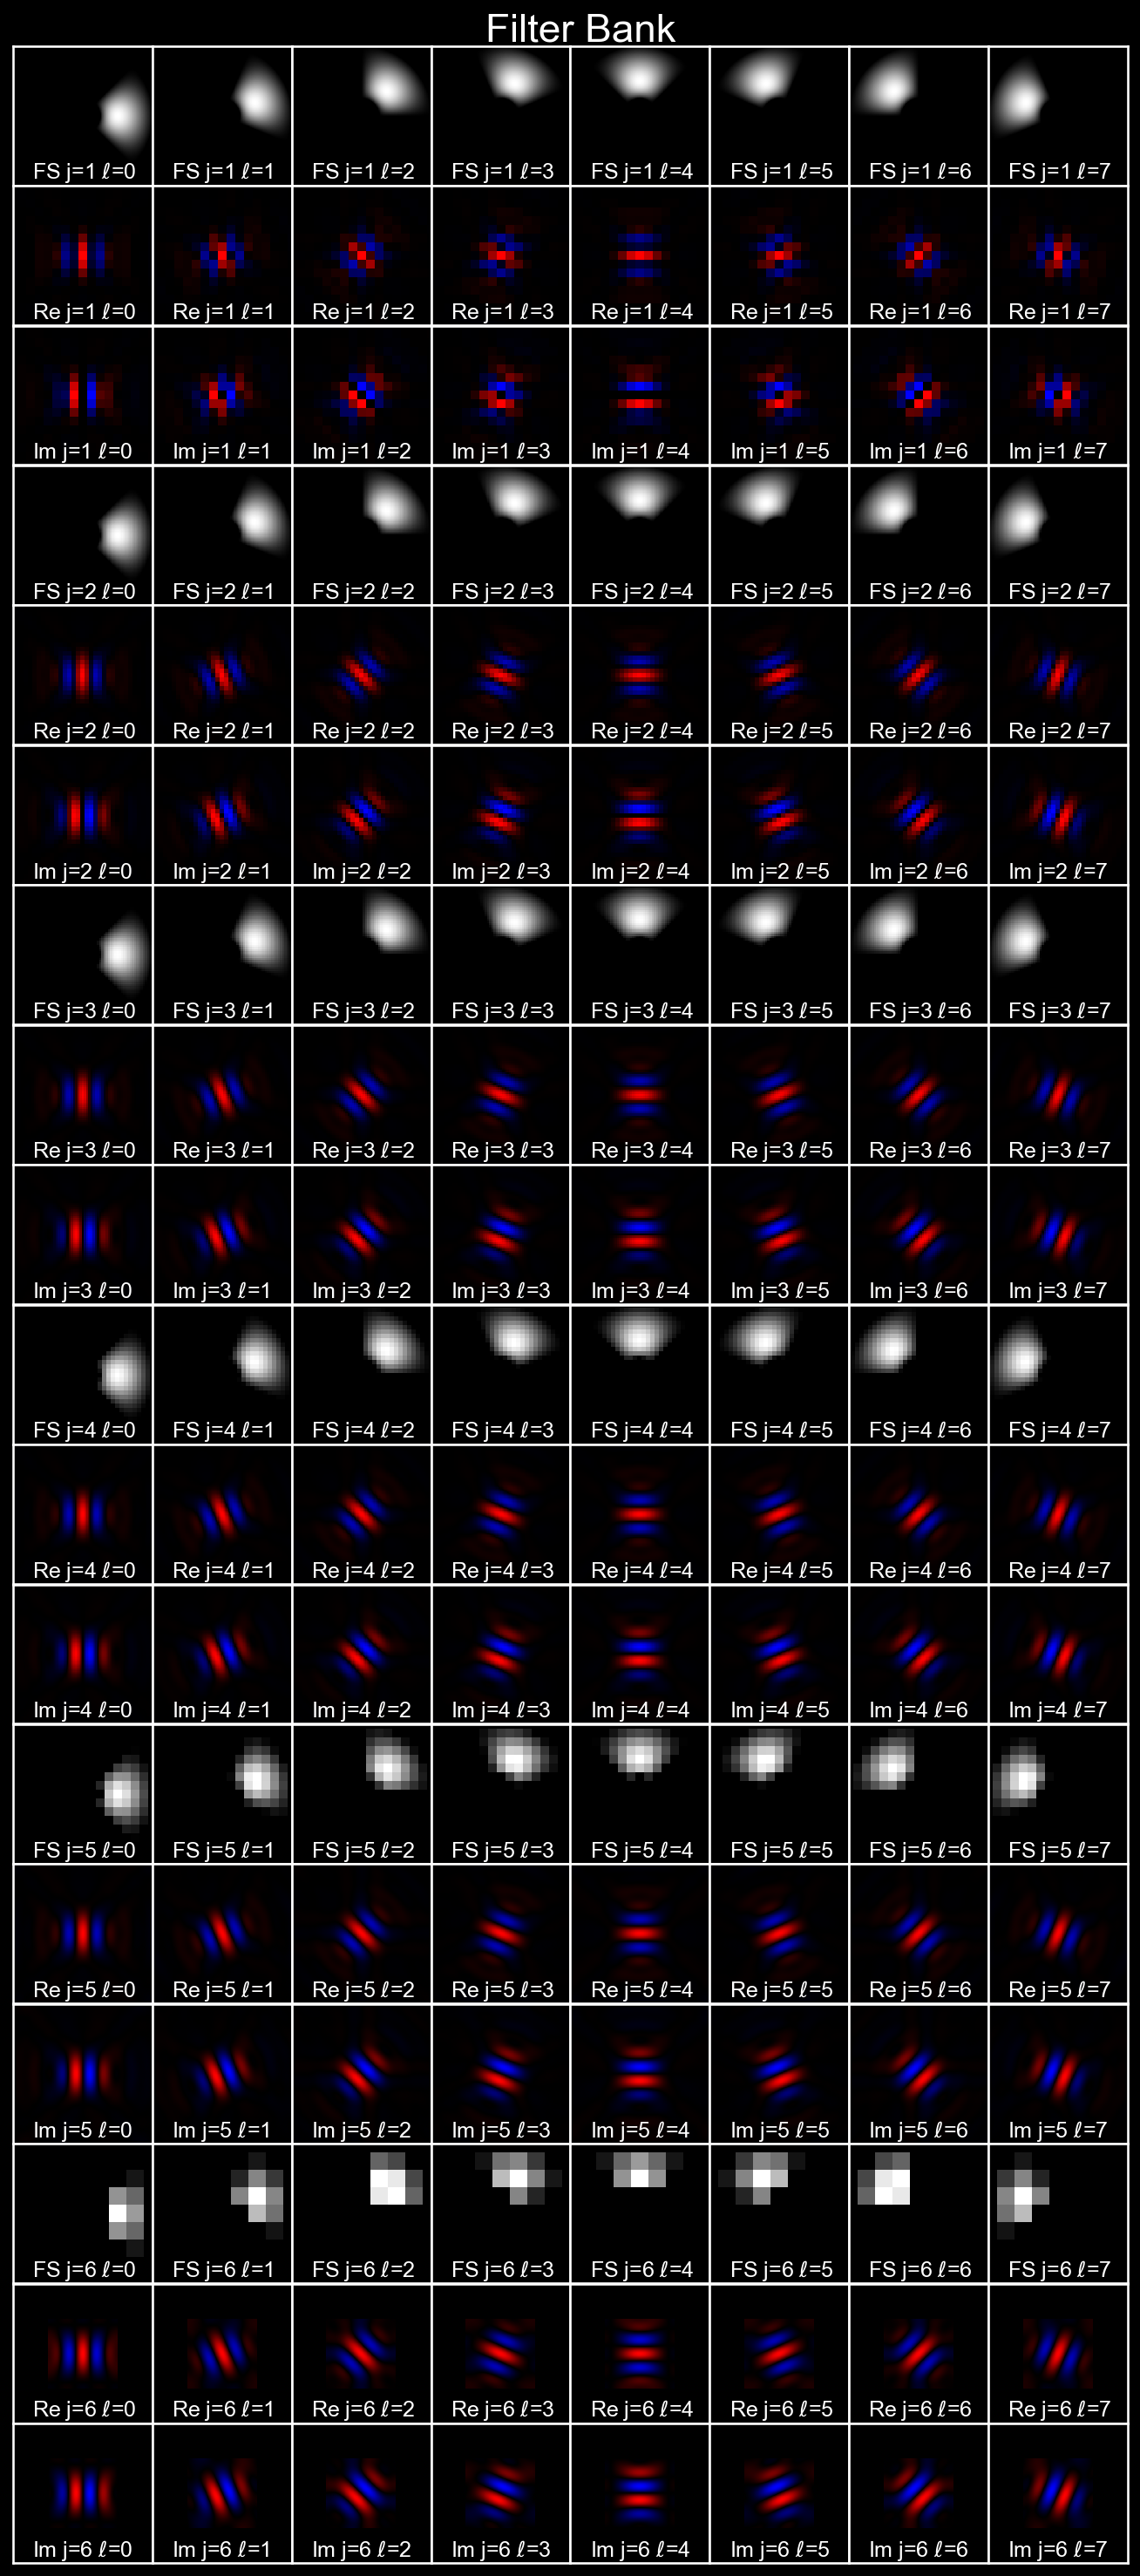

In [854]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')

def subplotter(data,fig,subplotx,subploty,subplotindx,j):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    ax.imshow(
        np.fft.fftshift(data).T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
    ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])
    ax.text(0.14, 0.05, 'FS j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])
    ax = fig.add_subplot(subplotx,subploty,subplotindx+8)
    ax.imshow(
        np.real(np.fft.fftshift(fft2(data)).T),
        vmin=-scale,
        vmax=scale,
        origin='lower',
        interpolation='nearest',
        cmap=blue_red1,
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Re j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    ax = fig.add_subplot(subplotx,subploty,subplotindx+16)
    ax.imshow(
        np.imag(np.fft.fftshift(fft2(data)).T),
        origin='lower',
        interpolation='nearest',
        cmap=blue_red1,
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Im j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)
    return

fig = plt.figure(figsize=(11,25.5), dpi=150)
for j in range(6):
    for l in range(8):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
        subplotter(data,fig,6*3,8,j*8*3+l+1,j)

plt.suptitle('Filter Bank',size=22,x=0.52,y=0.89)
fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('../figures/FinkletBankDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 3

In [947]:
import itertools
import sklearn

In [966]:
rod_corner = hd5_open('../scratch_AKS/paper_data/corner_rod.h5','main/coeffs')
rod_corner_lab = hd5_open('../scratch_AKS/paper_data/corner_rod.h5','main/labels')

In [967]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/labels')

In [968]:
rod_ex_images = hd5_open('../scratch_AKS/paper_data/images.h5','main/data')
rod_ex_curves = hd5_open('../scratch_AKS/paper_data/curves.h5','main/data')

In [969]:
def angle_plots(fig,index_data, data, subplotx,subploty,subplotindx,l):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[l],
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    #ax.axes.yaxis.set_ticks([])
    ax.set_ylabel('$\Delta$')
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    plt.vlines(l*180/8+90,0,361,'k','--',alpha=0.5)
    plt.vlines(l*180/8+180+90,0,361,'k','--',alpha=0.5)
    ax.set_xlim(0,361)
    return temp_mat[:,180]

In [970]:
def angle_plots_strip(index_data, data,l):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,180]

In [971]:
def curve_plots_strip(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,indx]

In [972]:
def curve_plots(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    #ax.axes.yaxis.set_ticks([])
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    ax.set_yticks([0,90,180,270,360])
    ax.set_yticklabels((0,0.25,0.5,0.75,1.0))
    ax.set_ylabel('$f_{bend}$')
    
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    
    if l==0:
        plt.hlines(0,0,361,'r','--',alpha=0.5)
        plt.hlines(90,0,361,'b','--',alpha=0.5)
        plt.hlines(360,0,361,'g','--',alpha=0.5)
    ax.set_xlim(0,361)
        
    return temp_mat[:,indx]

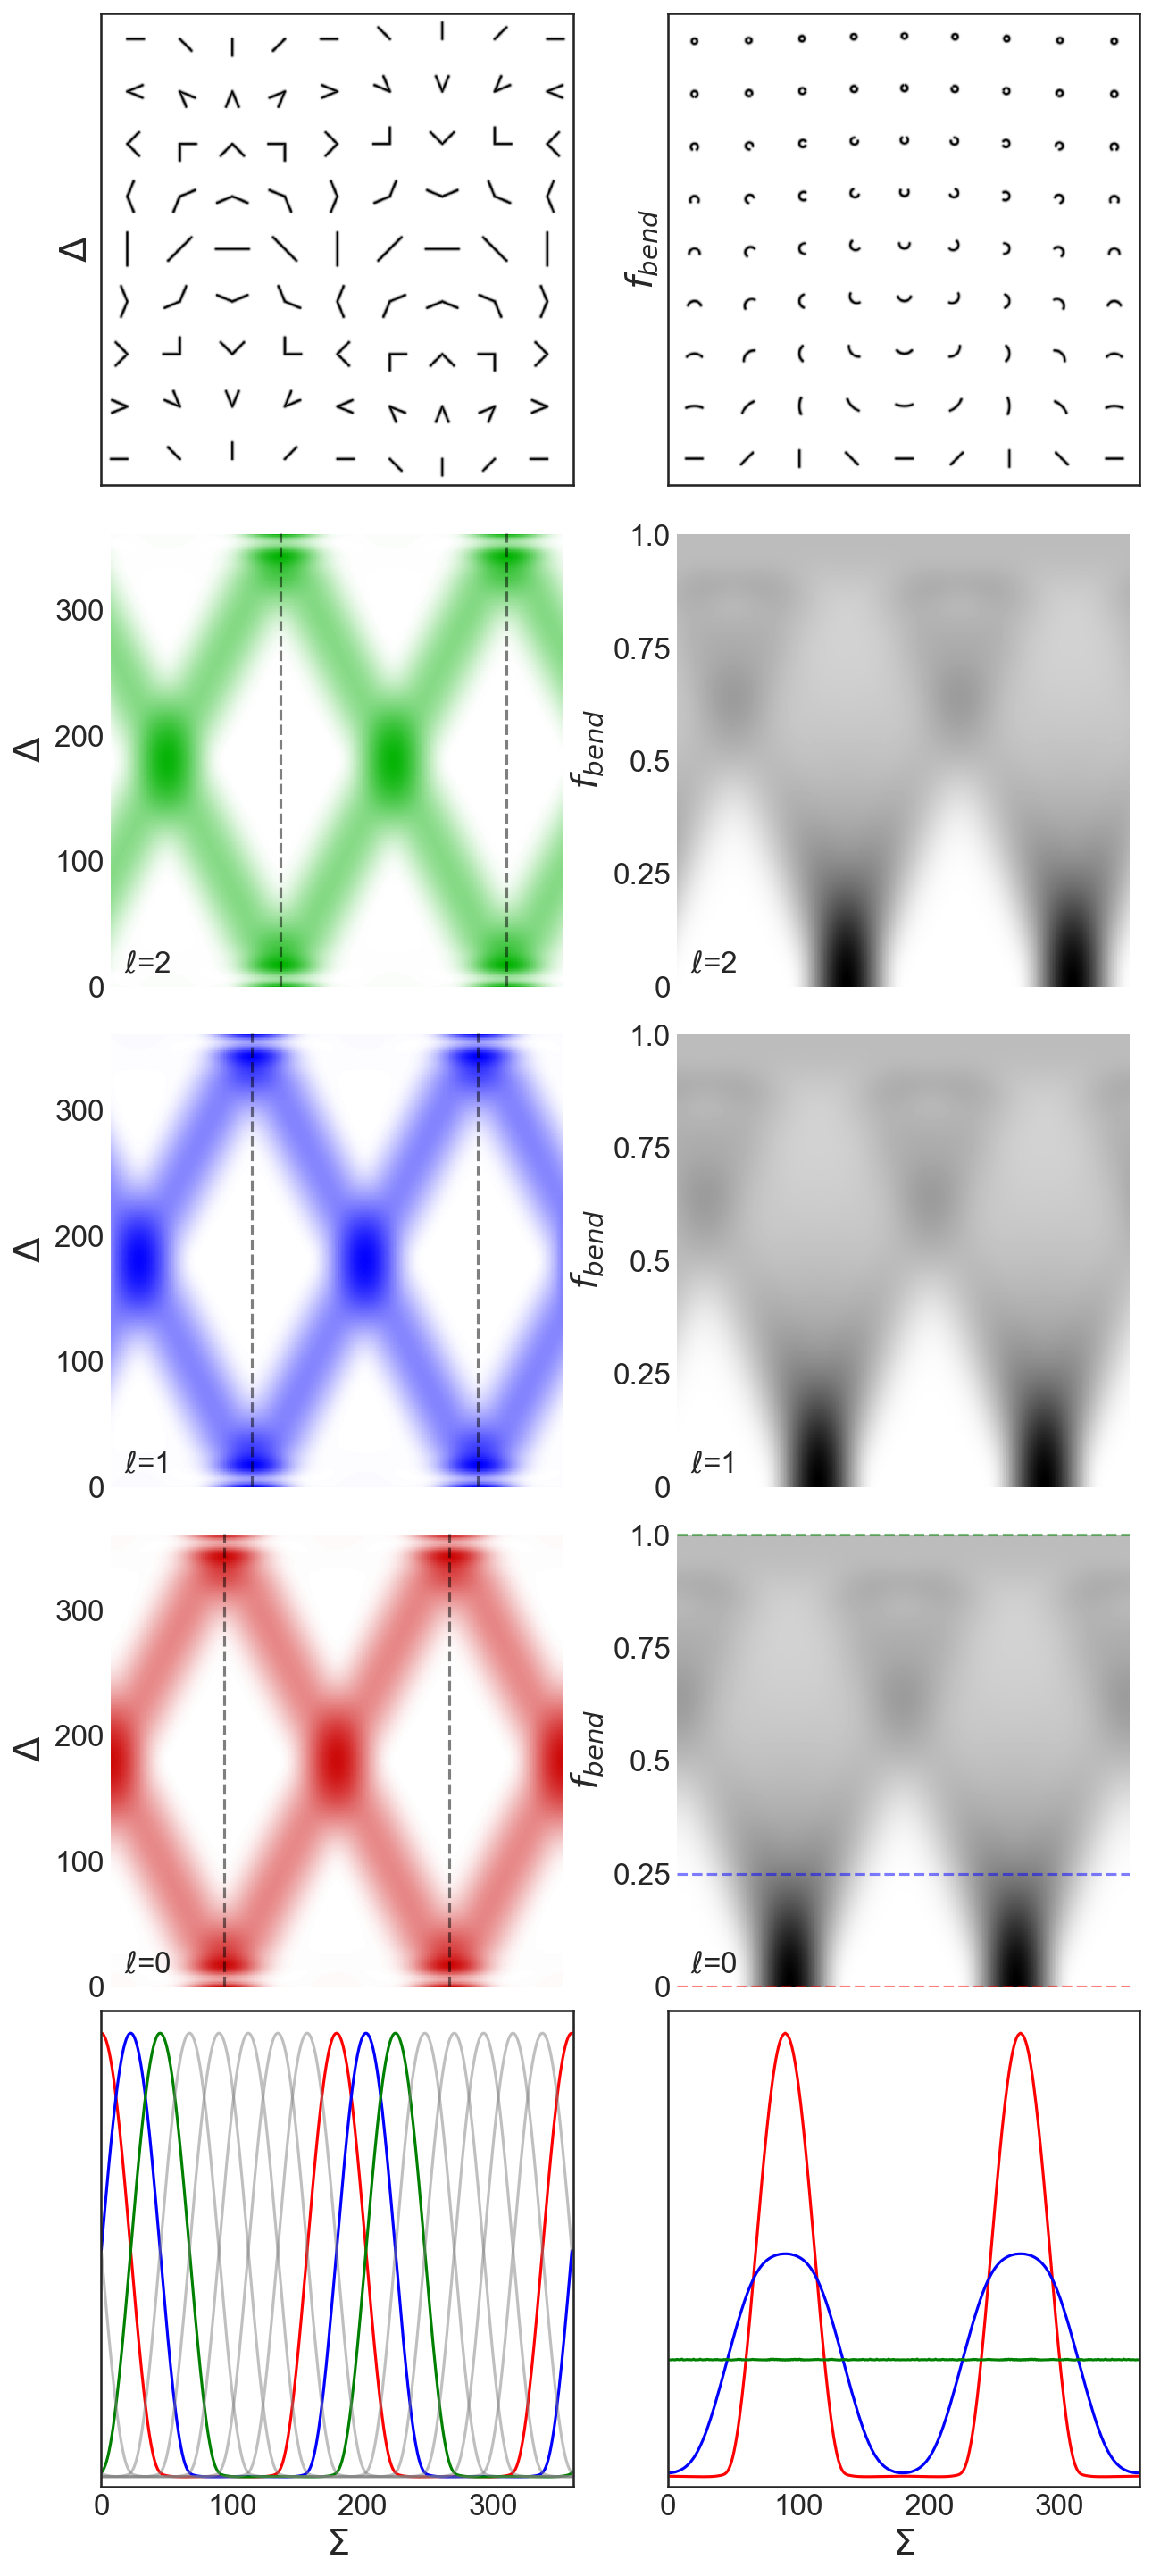

In [974]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(10,24), dpi=150)

ax = fig.add_subplot(5,2,1)
ax.imshow(
    rod_ex_images,
    #origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$\Delta$')

series = np.zeros((8,361))
for l in range(3):
    series[l,:] = angle_plots(fig,rod_corner_lab[:,0:2],rod_corner,5,2,2*(4-l)-1,l)

color_list = ['r','b','g']


for l in range(8):
    series[l,:] = angle_plots_strip(rod_corner_lab[:,0:2],rod_corner,l)

ax = fig.add_subplot(5,2,9)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
for i in range(3,8):
    ax.plot(series[i,:],color='grey',alpha=0.5)
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.set_xlabel('$\Sigma$')
ax.axes.yaxis.set_ticks([])

####

ax = fig.add_subplot(5,2,2)
ax.imshow(
    rod_ex_curves,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$f_{bend}$')

for l in range(3):
    series[l,:] = curve_plots(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,0)

l=0
temp_ind = 0
series = np.zeros((3,361))
for indx in [0,90,360]:
    series[temp_ind,:] = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,indx)
    temp_ind+=1

color_list = ['r','b','g']
ax = fig.add_subplot(5,2,10)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.axes.yaxis.set_ticks([])
ax.set_xlabel('$\Sigma$')

fig.subplots_adjust(hspace=0.05,wspace=0.2)
plt.savefig('../figures/RotEquiv.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

In [655]:
def pwr_plots_strip(index_data,l,indx):
    temp_mat = np.zeros((361,361))
    indexes = index_data[:,0:2]
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = index_data[index,2]
    
    return temp_mat[:,indx]

In [656]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/labels')

In [658]:
temp = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),0,360)
pwr_tmp = pwr_plots_strip(rod_curve_lab,0,360)
(temp.max()-temp.min())/temp.mean(), np.std(temp)/temp.mean(), (pwr_tmp.max()-pwr_tmp.min())/pwr_tmp.mean(), np.std(pwr_tmp)/np.mean(pwr_tmp)

(0.008863147265114715,
 0.0019506220059125484,
 0.00149034977933371,
 0.00032221735254916653)

In [647]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40_10.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40_10.h5','main/labels')

In [659]:
temp = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),0,360)
(temp.max()-temp.min())/temp.mean(), np.std(temp)/temp.mean(), (pwr_tmp.max()-pwr_tmp.min())/pwr_tmp.mean(), np.std(pwr_tmp)/np.mean(pwr_tmp)

(0.008863147265114715,
 0.0019506220059125484,
 0.00149034977933371,
 0.00032221735254916653)

In [639]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod.h5','main/labels')

In [660]:
temp = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),0,360)
(temp.max()-temp.min())/temp.mean(), np.std(temp)/temp.mean(), (pwr_tmp.max()-pwr_tmp.min())/pwr_tmp.mean(), np.std(pwr_tmp)/np.mean(pwr_tmp)

(0.008863147265114715,
 0.0019506220059125484,
 0.00149034977933371,
 0.00032221735254916653)

In [975]:
def curve_plots(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    ax.set_yticks([0,90,180,270,360])
    ax.set_yticklabels((0,0.25,0.5,0.75,1.0))
    ax.set_ylabel('$f_{bend}$')
    
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    
    if l==0:
        plt.hlines(0,0,361,'r','--',alpha=0.5)
        plt.hlines(90,0,361,'b','--',alpha=0.5)
        plt.hlines(360,0,361,'g','--',alpha=0.5)
    ax.set_xlim(0,361)
        
    return temp_mat[:,indx]

def angle_plots(fig,index_data, data, subplotx,subploty,subplotindx,l):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[l],
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.set_ylabel('$\Delta$')
    ax.text(0.03, 0.03, '$\ell$={}'.format(l), transform=ax.transAxes, size=16)
    
    plt.vlines(l*180/8+90,0,361,'w','--',alpha=0.5)
    plt.vlines(l*180/8+180+90,0,361,'w','--',alpha=0.5)
    ax.set_xlim(0,361)
    return temp_mat[:,180]

def angle_plots_strip(index_data, data,l):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,180]

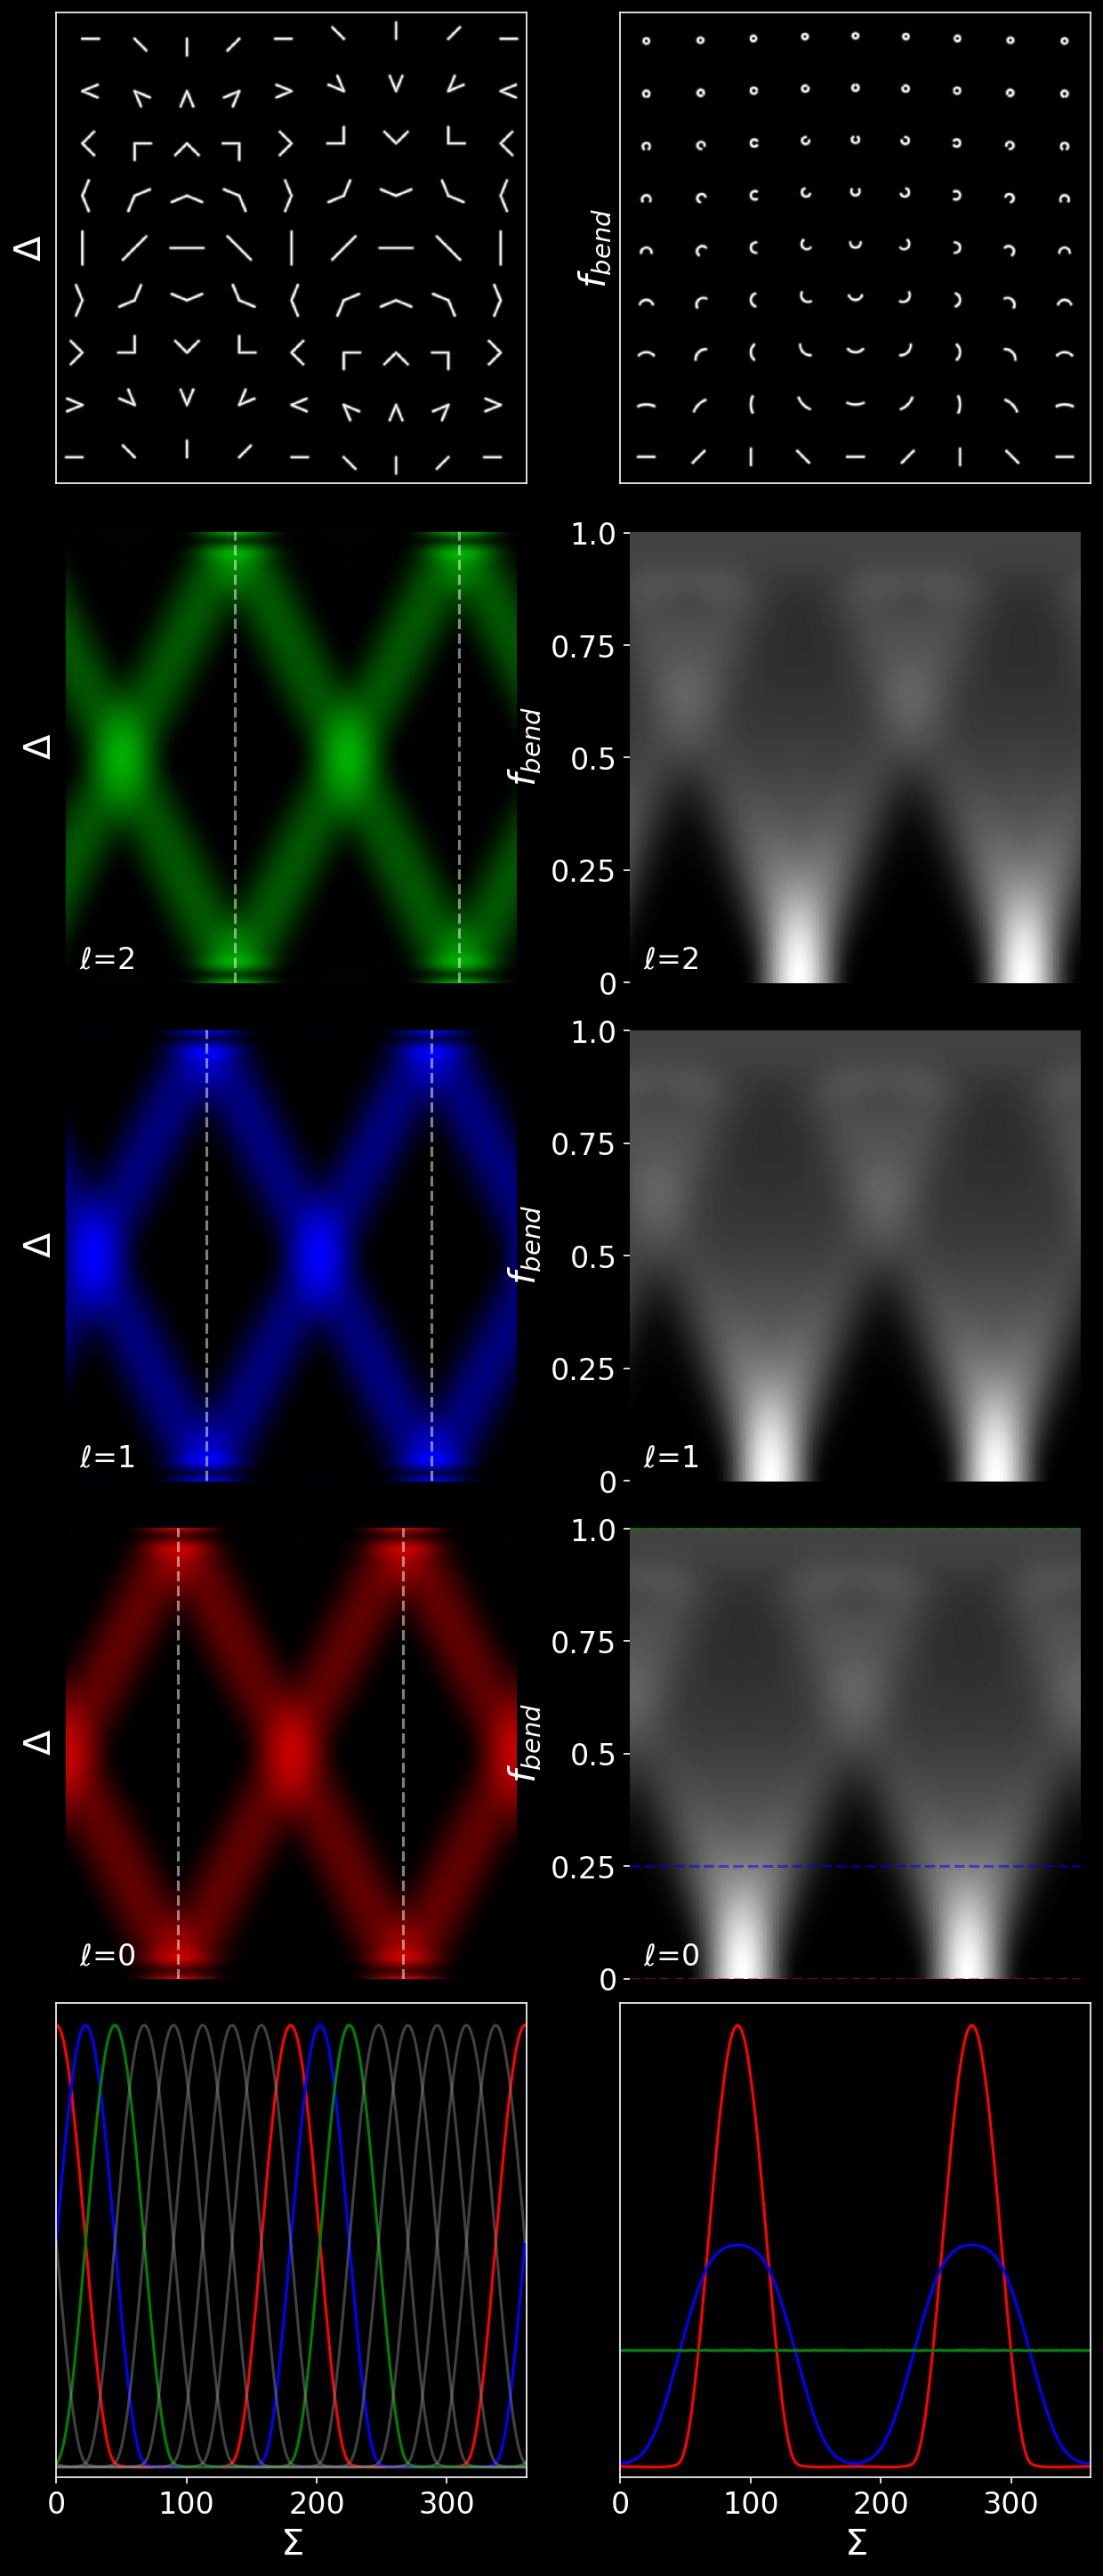

In [976]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,24), dpi=150)

ax = fig.add_subplot(5,2,1)
ax.imshow(
    rod_ex_images,
    #origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$\Delta$')

series = np.zeros((8,361))
for l in range(3):
    series[l,:] = angle_plots(fig,rod_corner_lab[:,0:2],rod_corner,5,2,2*(4-l)-1,l)

color_list = ['r','b','g']
for l in range(8):
    series[l,:] = angle_plots_strip(rod_corner_lab[:,0:2],rod_corner,l)

ax = fig.add_subplot(5,2,9)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
for i in range(3,8):
    ax.plot(series[i,:],color='grey',alpha=0.5)
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.set_xlabel('$\Sigma$')
ax.axes.yaxis.set_ticks([])

####

ax = fig.add_subplot(5,2,2)
ax.imshow(
    rod_ex_curves,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$f_{bend}$')

for l in range(3):
    series[l,:] = curve_plots(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,0)

l=0
temp_ind = 0
series = np.zeros((3,361))
for indx in [0,90,360]:
    series[temp_ind,:] = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,indx)
    temp_ind+=1

color_list = ['r','b','g']
ax = fig.add_subplot(5,2,10)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.set_ylim(bottom=0)
ax.axes.yaxis.set_ticks([])
ax.set_xlabel('$\Sigma$')

fig.subplots_adjust(hspace=0.05,wspace=0.2)
plt.savefig('../figures/RotEquivDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 4

In [936]:
disc_data = hd5_open('../scratch_AKS/paper_data/disc_data_log.h5','main/coeffs')
disc_data_lab = hd5_open('../scratch_AKS/paper_data/disc_data_log.h5','main/labels')

In [937]:
indexes = copy.deepcopy(disc_data_lab)
list_scales = np.unique(indexes[:,0])
indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]

In [938]:
def radial_plots(fig,index_data, data, subplotx,subploty,subplotindx,j,color_set):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = copy.deepcopy(index_data)
    list_scales = np.unique(indexes[:,0])
    indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
    list_psfs = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_psfs==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,1+j-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    psfs_list = [np.argmin(np.abs(list_psfs-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    
    if np.logical_or(j==6,j==7):
        ax.set_xticks(lines_list)
        ax.set_xticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_xlabel('Radius')
        
    if np.any([j==2,j==4,j==6]):
        ax.set_yticks(psfs_list)
        ax.set_yticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_ylabel('FWHM')
    
    plt.vlines(lines_list[j-2],0,361,'r','--',alpha=1)
    if psfs_list[j-2] < 360:
        plt.hlines(psfs_list[j-2],0,361,'r','--',alpha=1)
    
    plt.hlines(psfs_list[1],0,361,color_set,'--',alpha=1)
    
    if j <5:
        ax.text(0.87, 0.89, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
    if j>4:
        ax.text(0.03, 0.03, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
        

    ax.set_xlim(0,361)
        
    return temp_mat[:,psfs_list[1]]

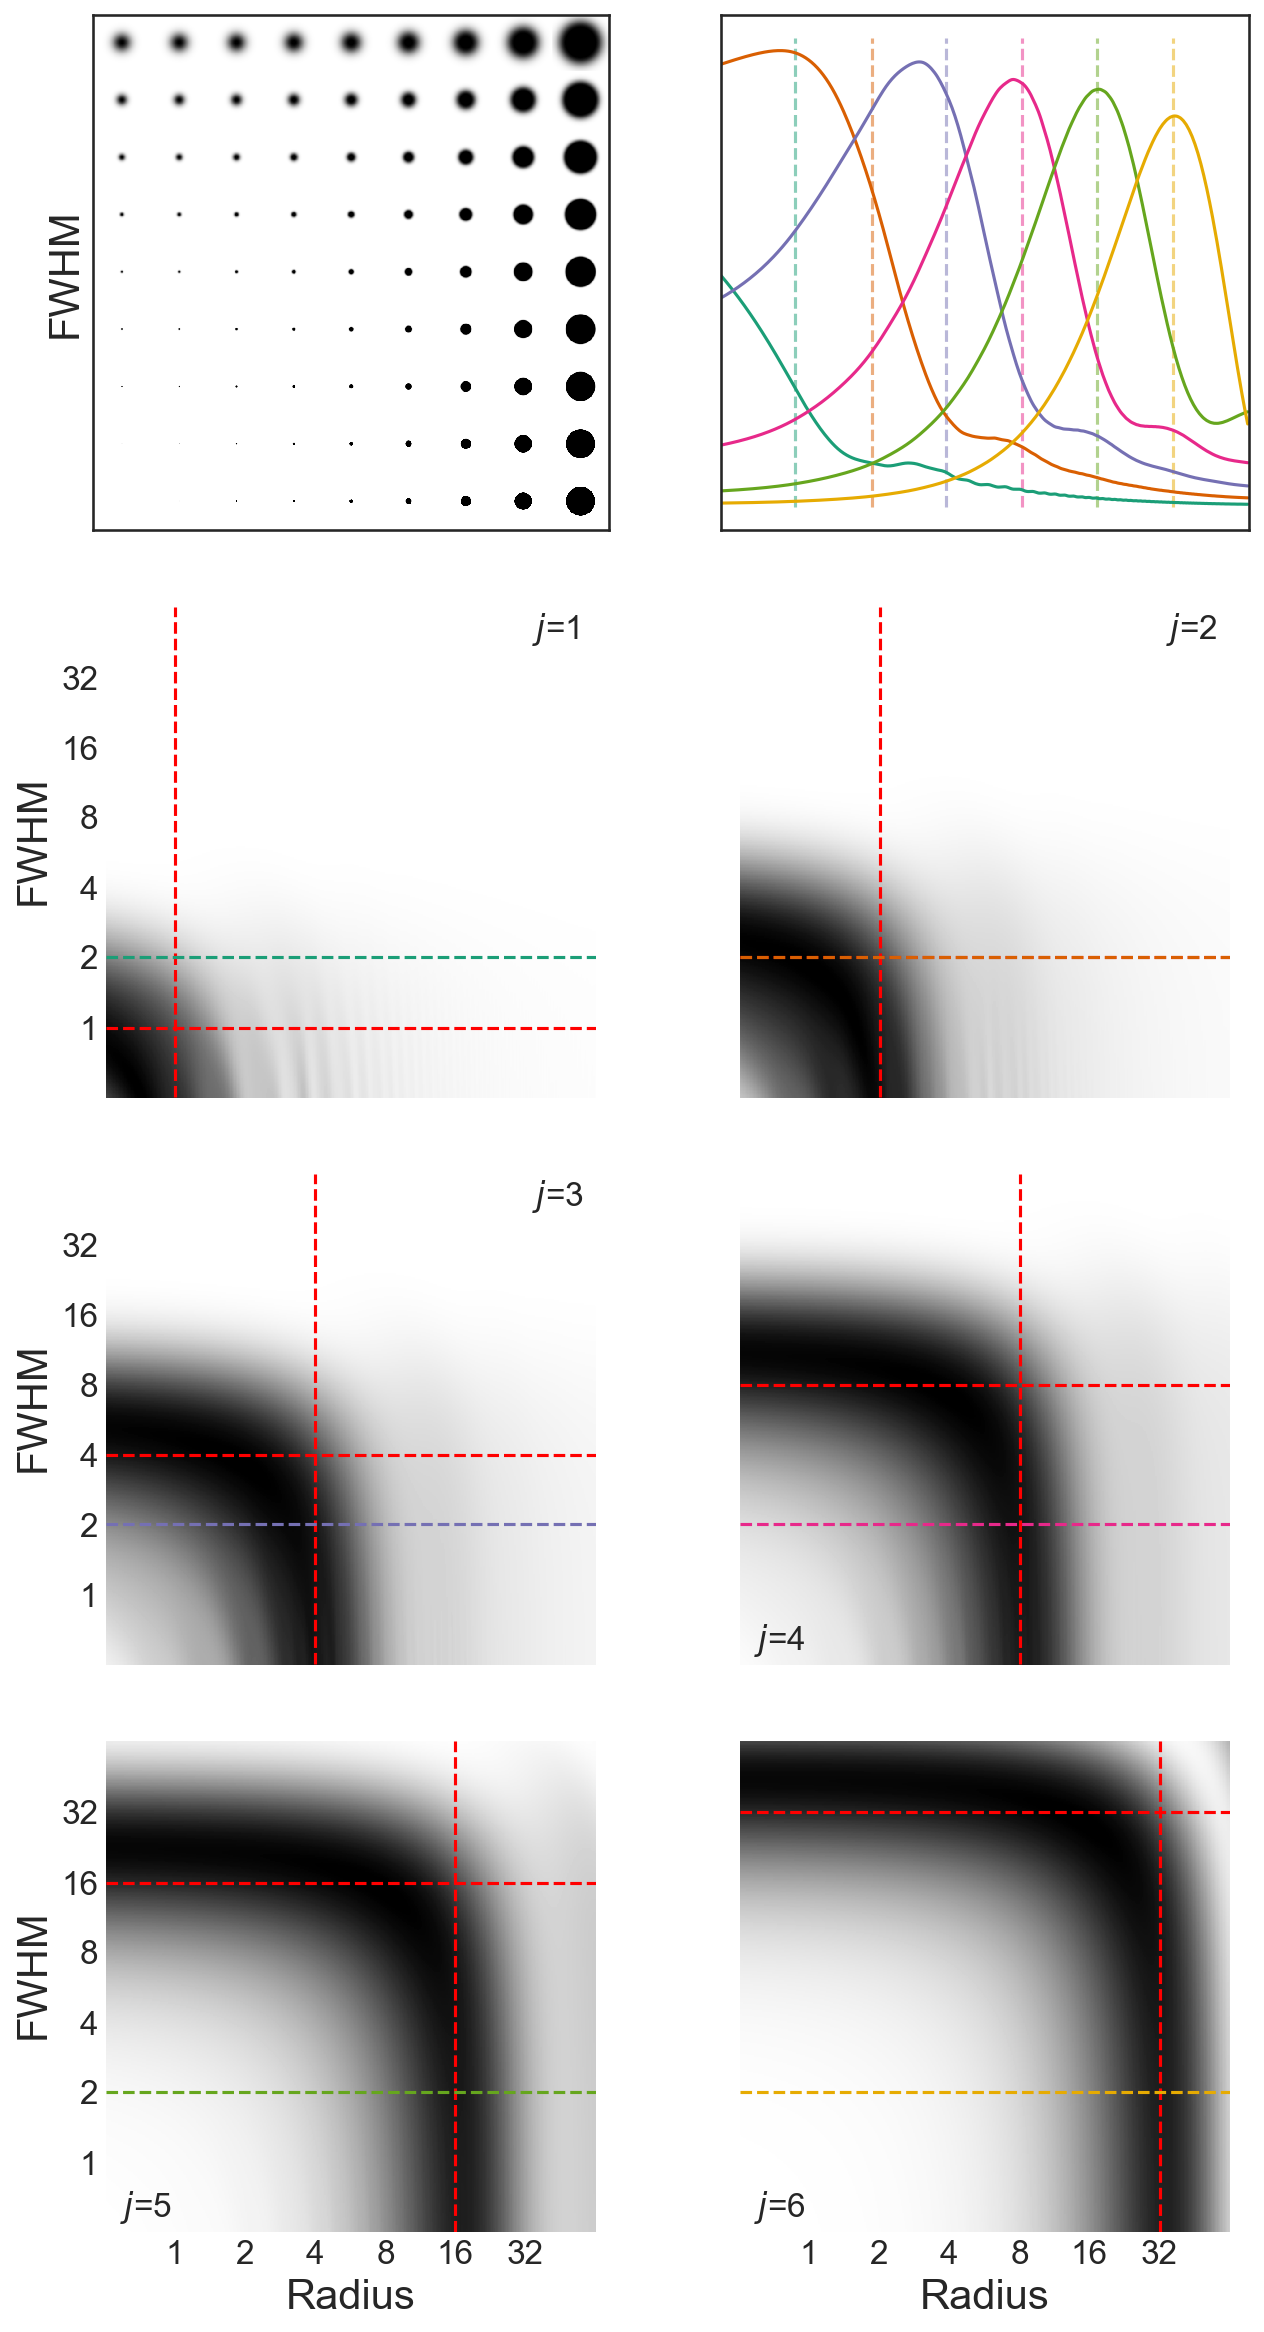

In [939]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(10,19.2), dpi=150)

ax = fig.add_subplot(4,2,1)
ax.imshow(
    disc_ex_images,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('FWHM')

series = np.zeros((6,361))
cmap = mpl.cm.get_cmap('Dark2')
for j in range(2,8):
    series[j-2,:] = radial_plots(fig,disc_data_lab[:,0:2],disc_data,4,2,2+j-1,j,cmap(j-2))

ax = fig.add_subplot(4,2,2)
for i in range(0,6):
    ax.plot(series[i,:],color=cmap(i))
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])
i=0
for x in lines_list:
    plt.vlines(x,0,.06,cmap(i),'--',alpha=0.5)
    i+=1
    
fig.subplots_adjust(hspace=0.1,wspace=0.2)
plt.savefig('../figures/ScaleEquiv.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

In [934]:
def radial_plots(fig,index_data, data, subplotx,subploty,subplotindx,j,color_set):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = copy.deepcopy(index_data)
    list_scales = np.unique(indexes[:,0])
    indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
    list_psfs = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_psfs==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,1+j-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    psfs_list = [np.argmin(np.abs(list_psfs-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    
    if np.logical_or(j==6,j==7):
        ax.set_xticks(lines_list)
        ax.set_xticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_xlabel('Radius')
        
    if np.any([j==2,j==4,j==6]):
        ax.set_yticks(psfs_list)
        ax.set_yticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_ylabel('FWHM')
    
    plt.vlines(lines_list[j-2],0,361,'r','--',alpha=1)
    if psfs_list[j-2] < 360:
        plt.hlines(psfs_list[j-2],0,361,'r','--',alpha=1)
    
    plt.hlines(psfs_list[1],0,361,color_set,'--',alpha=1)
    
    if j <5:
        ax.text(0.87, 0.89, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
    if j>4:
        ax.text(0.03, 0.03, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
        

    ax.set_xlim(0,361)
        
    return temp_mat[:,psfs_list[1]]

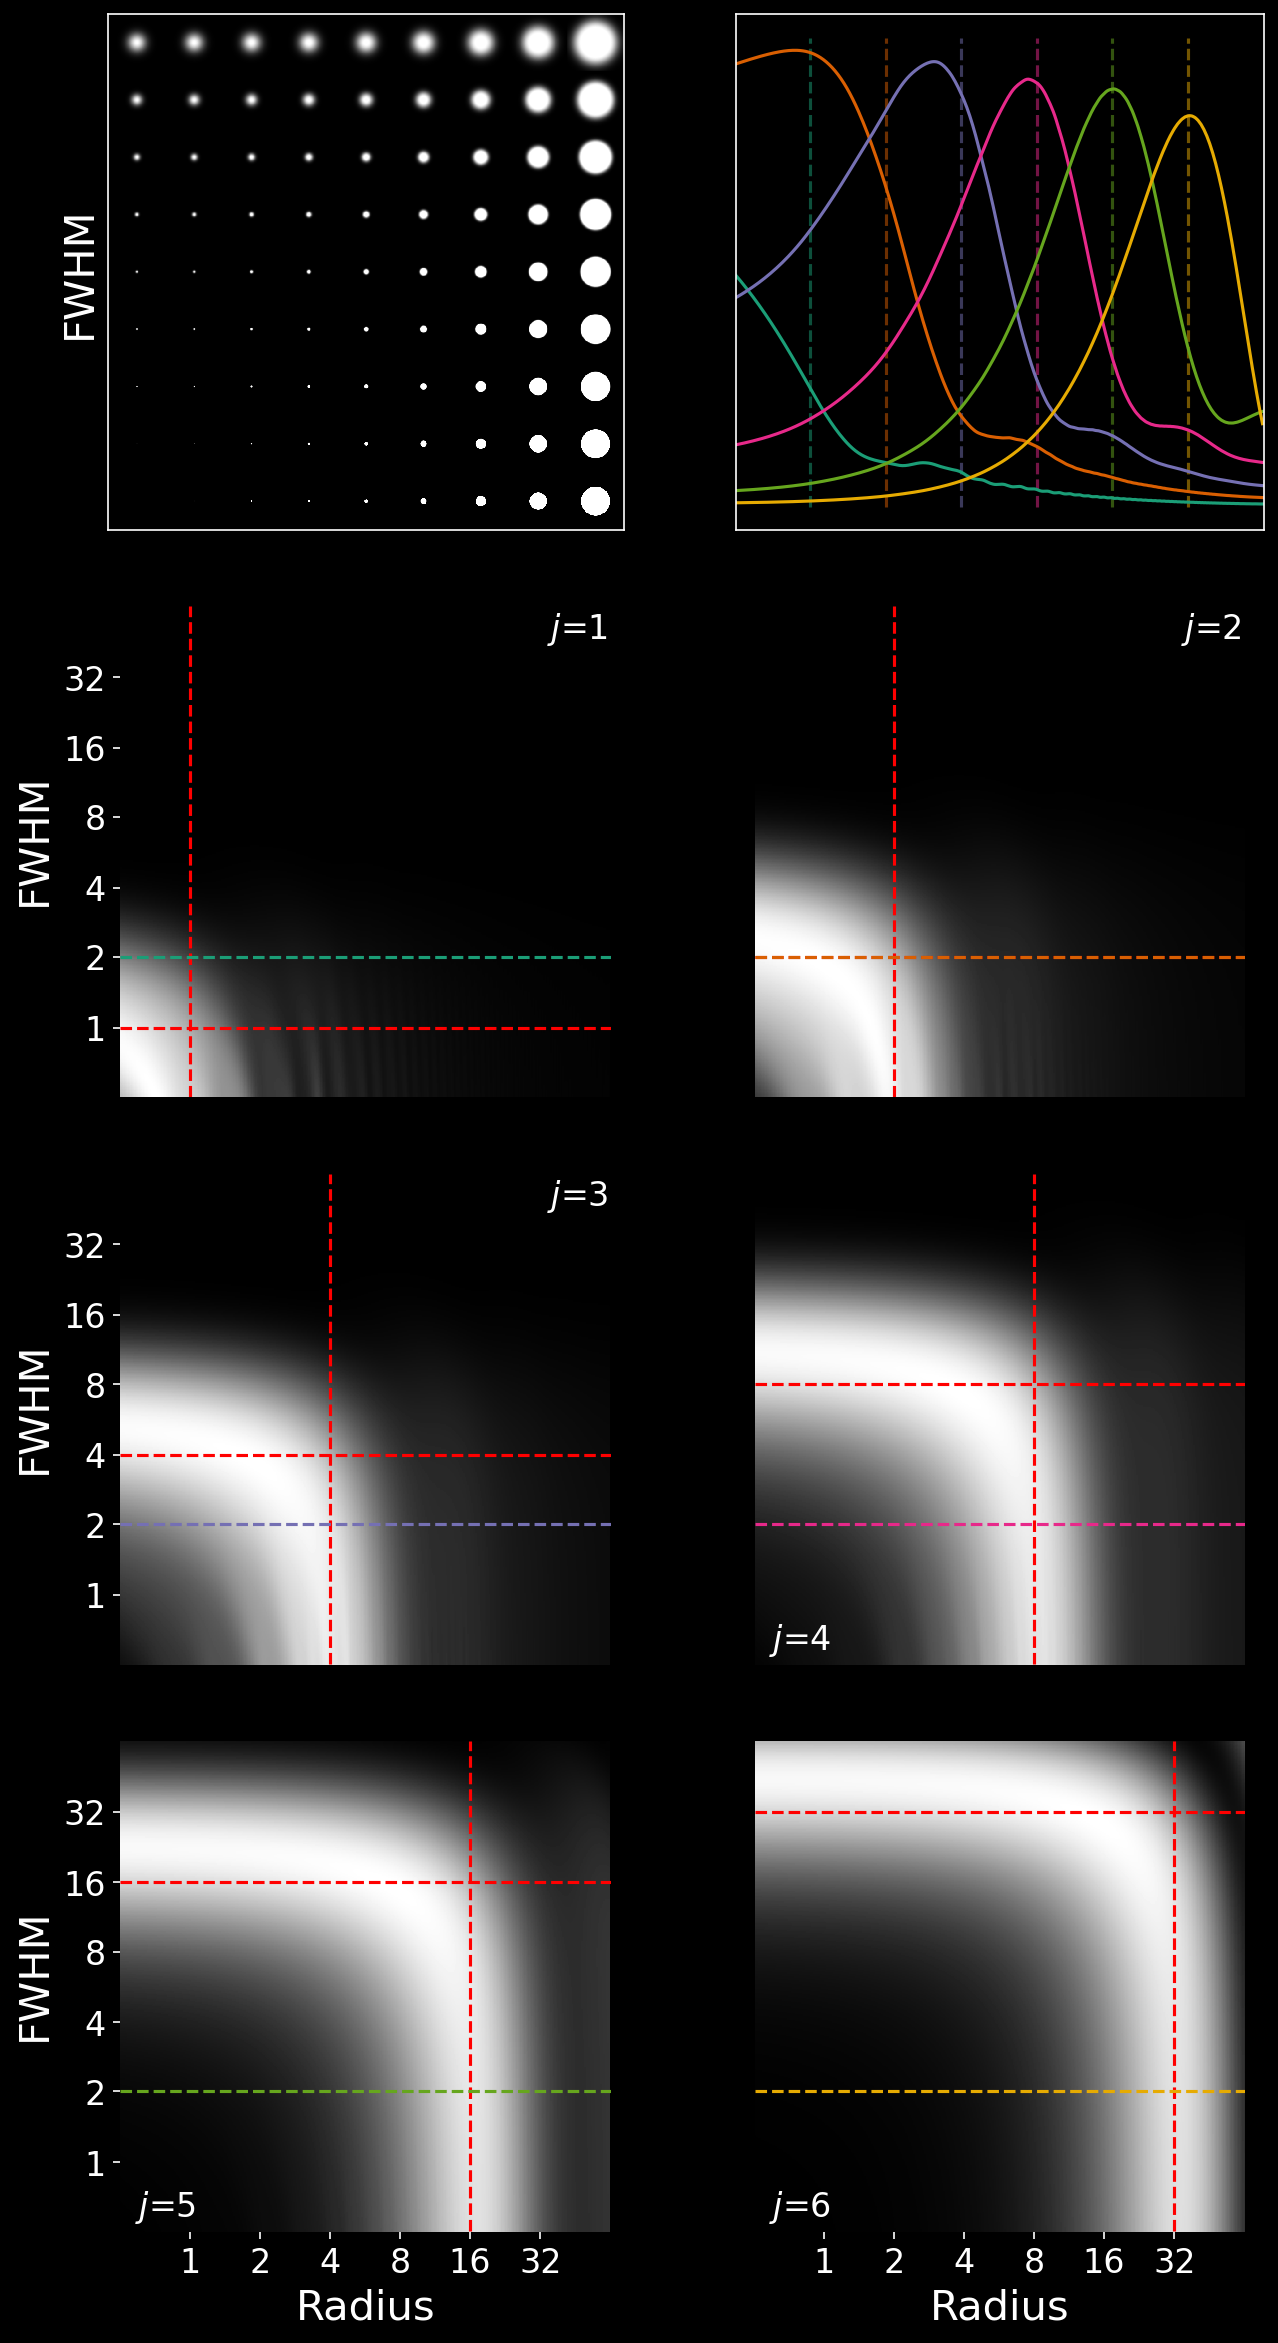

In [935]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,19.2), dpi=150)

ax = fig.add_subplot(4,2,1)
ax.imshow(
    disc_ex_images,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('FWHM')

series = np.zeros((6,361))
cmap = mpl.cm.get_cmap('Dark2')
for j in range(2,8):
    series[j-2,:] = radial_plots(fig,disc_data_lab[:,0:2],disc_data,4,2,2+j-1,j,cmap(j-2))

ax = fig.add_subplot(4,2,2)
for i in range(0,6):
    ax.plot(series[i,:],color=cmap(i))
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])
i=0
for x in lines_list:
    plt.vlines(x,0,.06,cmap(i),'--',alpha=0.5)
    i+=1
    
fig.subplots_adjust(hspace=0.1,wspace=0.2)
plt.savefig('../figures/ScaleEquivDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

In [977]:
def radial_plots(fig,index_data, data, subplotx,subploty,subplotindx,j,color_set):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = copy.deepcopy(index_data)
    list_scales = np.unique(indexes[:,0])
    indexes[:,0] = [np.where(list_scales==x)[0][0] for x in indexes[:,0]]
    list_psfs = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_psfs==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,1+j-1]

    #row_sums = temp_mat.sum(axis=1)
    #temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap='gray',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    lines_list = [np.argmin(np.abs(list_scales-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    psfs_list = [np.argmin(np.abs(list_psfs-x)) for x in [2**(k-1) for k in [1,2,3,4,5,6]]]
    
    if np.logical_or(j==6,j==7):
        ax.set_xticks(lines_list)
        ax.set_xticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_xlabel('Radius')
        
    if np.any([j==2,j==4,j==6]):
        ax.set_yticks(psfs_list)
        ax.set_yticklabels([2**(k-1) for k in [1,2,3,4,5,6]])
        ax.set_ylabel('FWHM')
    
    plt.vlines(lines_list[j-2],0,361,'r','--',alpha=1)
    if psfs_list[j-2] < 360:
        plt.hlines(psfs_list[j-2],0,361,'r','--',alpha=1)
    
    plt.hlines(psfs_list[1],0,361,color_set,'--',alpha=1)
    
    if j <5:
        ax.text(0.87, 0.89, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
    if j>4:
        ax.text(0.03, 0.03, '$j$={}'.format(j-1), transform=ax.transAxes, size=16)
        

    ax.set_xlim(0,361)
        
    return temp_mat[:,0]

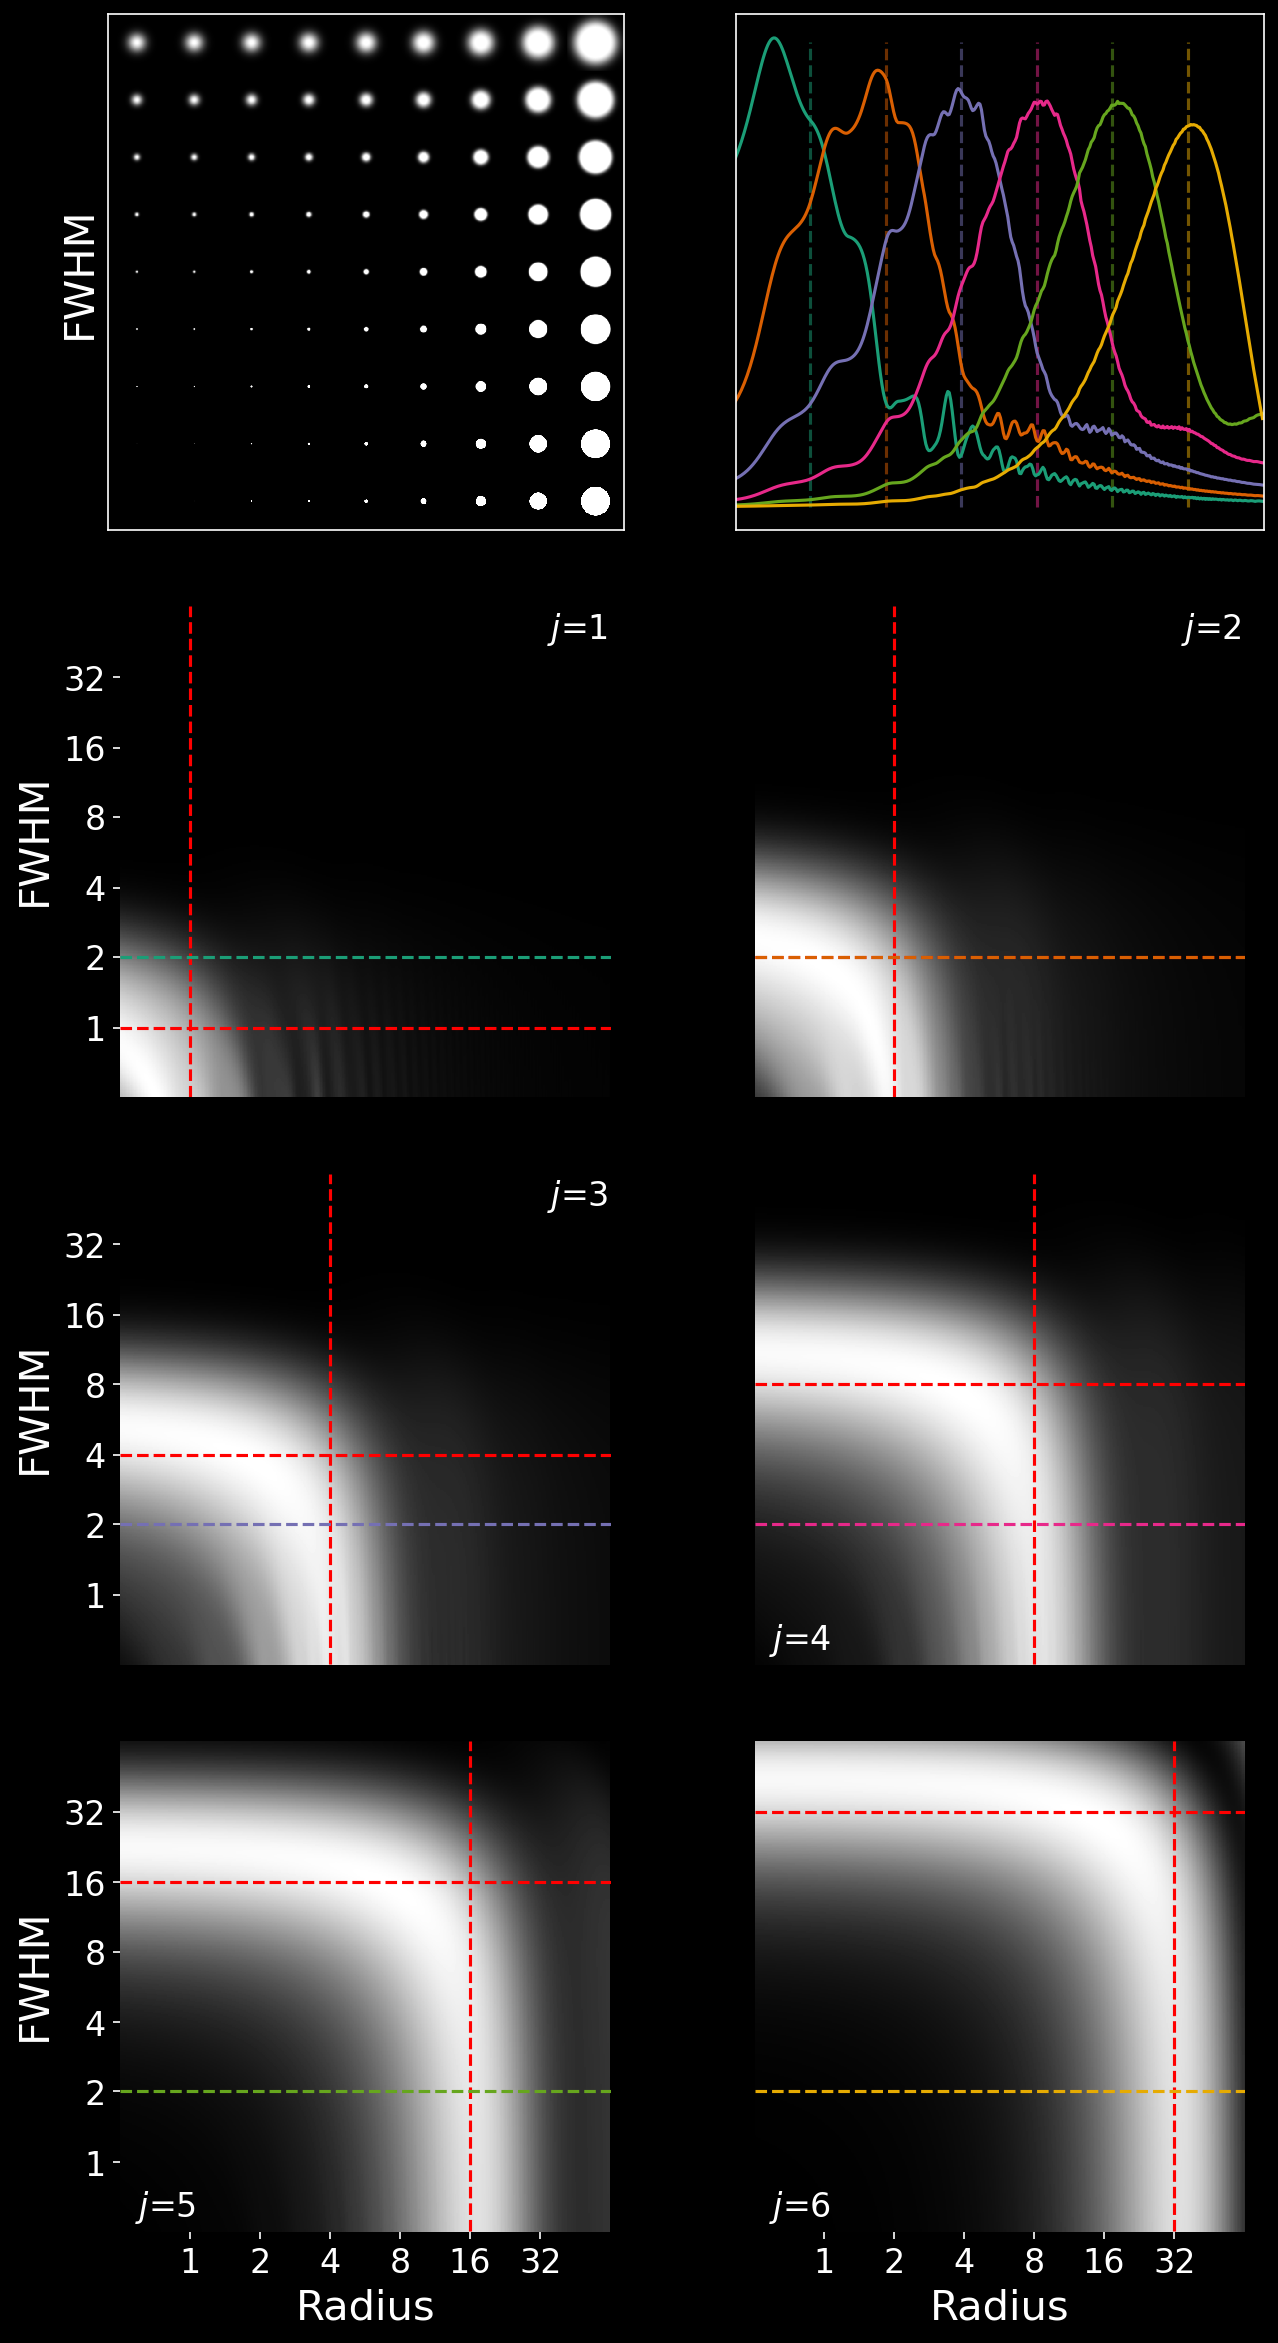

In [978]:
##
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,19.2), dpi=150)

ax = fig.add_subplot(4,2,1)
ax.imshow(
    disc_ex_images,
    origin='lower',
    interpolation='nearest',
    cmap='gray',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('FWHM')

series = np.zeros((6,361))
cmap = mpl.cm.get_cmap('Dark2')
for j in range(2,8):
    series[j-2,:] = radial_plots(fig,disc_data_lab[:,0:2],disc_data,4,2,2+j-1,j,cmap(j-2))

ax = fig.add_subplot(4,2,2)
for i in range(0,6):
    ax.plot(series[i,:],color=cmap(i))
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])
i=0
for x in lines_list:
    plt.vlines(x,0,.06,cmap(i),'--',alpha=0.5)
    i+=1
    
fig.subplots_adjust(hspace=0.1,wspace=0.2)
#plt.savefig('../figures/ScaleEquivDark.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Stablity plot

In [5]:
mnist_DHC_out_angles = hd5_open('../from_cannon/2021_01_20/mnist_DHC_test_angles.h5','main/data')

In [6]:
mnist_train_y = hd5_open('../scratch_AKS/data/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/data/mnist_test_y.h5','main/data')

mnist_DHC_out = hd5_open('../scratch_AKS/data/mnist_DHC_out.h5','main/data')
mnist_DHC_out_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_test.h5','main/data')

mnist_DHC_out_rot7pi = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot7pi_8.h5','main/data')
mnist_DHC_out_rot7pi_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot7pi_8_test.h5','main/data')

mnist_DHC_out_rotpi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rotpi_3.h5','main/data')
mnist_DHC_out_rotpi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rotpi_3_test.h5','main/data')

mnist_DHC_out_rot2pi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot2pi_3.h5','main/data')
mnist_DHC_out_rot2pi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot2pi_3_test.h5','main/data')

mnist_DHC_out_rot3pi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot3pi_3.h5','main/data')
mnist_DHC_out_rot3pi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot3pi_3_test.h5','main/data')

mnist_DHC_out_rot4pi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot4pi_3.h5','main/data')
mnist_DHC_out_rot4pi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot4pi_3_test.h5','main/data')

mnist_DHC_out_rot5pi_3 = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot5pi_3.h5','main/data')
mnist_DHC_out_rot5pi_3_test = hd5_open('../scratch_AKS/data/mnist_DHC_out_rot5pi_3_test.h5','main/data')

mnist_DHC_out_stack = np.vstack((mnist_DHC_out, mnist_DHC_out_rotpi_3,mnist_DHC_out_rot2pi_3,mnist_DHC_out_rot3pi_3,mnist_DHC_out_rot4pi_3,mnist_DHC_out_rot5pi_3))
mnist_DHC_out_stack_test = np.vstack((mnist_DHC_out_test, mnist_DHC_out_rotpi_3_test,mnist_DHC_out_rot2pi_3_test,mnist_DHC_out_rot3pi_3_test,mnist_DHC_out_rot4pi_3_test,mnist_DHC_out_rot5pi_3_test))

mnist_DHC_out_stack_train_y = np.hstack((mnist_train_y,mnist_train_y,mnist_train_y,mnist_train_y,mnist_train_y,mnist_train_y))
mnist_DHC_out_stack_test_y = np.hstack((mnist_test_y,mnist_test_y,mnist_test_y,mnist_test_y,mnist_test_y,mnist_test_y))

In [7]:
def prec_LDA(lda,X_test,y_test):
    y_pred = lda.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    return prec

def DHC_iso(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [8]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso(mnist_DHC_out_stack,6,8), mnist_DHC_out_stack_train_y)

LinearDiscriminantAnalysis(n_components=9)

In [9]:
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso(mnist_DHC_out_angles[i::100,:],6,8),mnist_test_y))

In [10]:
M = 100
angles = [i for i in np.linspace(0,2*np.pi,100)]

In [ ]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(mnist_DHC_out_stack, mnist_DHC_out_stack_train_y)

prec_mnist_angles_noiso = []
for i in range(100):
    prec_mnist_angles_noiso.append(prec_LDA(lda,mnist_DHC_out_angles[i::100,:],mnist_test_y))

In [ ]:
hf = h5py.File('../scratch_AKS/data/prec_mnist_angles_noiso.h5', 'w')
hf.create_dataset('data', data=prec_mnist_angles_noiso)
hf.close()

hf = h5py.File('../scratch_AKS/data/prec_mnist_angles.h5', 'w')
hf.create_dataset('data', data=prec_mnist_angles)
hf.close()

In [ ]:
##
from matplotlib import transforms

mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(12,24),dpi=150)
ax = fig.add_subplot(211,projection='polar') 
ax.plot(angles,100*np.array(prec_mnist_angles_noiso), linestyle='-', marker='o',color='k')
plt.xlabel('Test Image Rotation Angle')
#plt.ylabel('True Positive Percentage')
plt.title('REG Accuracy Angle Dependence')
ax.set_ylim(100*np.array(prec_mnist_angles_noiso).min(),100*np.array(prec_mnist_angles_noiso).max())
plt.axvline(x=0.333*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=0.666*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=1.0*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=1.333*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=1.666*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=0.0*np.pi,linestyle='--',color='r',alpha=0.7)

ax.tick_params(pad=10)
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL, size=20)

ax = fig.add_subplot(212,projection='polar') 
ax.plot(angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o',color='k')
plt.xlabel('Test Image Rotation Angle')
#plt.ylabel('True Positive Percentage')
plt.title('ISO Accuracy Angle Dependence')
ax.set_ylim(100*np.array(prec_mnist_angles).min(),100*np.array(prec_mnist_angles).max())
plt.axvline(x=0.333*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=0.666*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=1.0*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=1.333*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=1.666*np.pi,linestyle='--',color='r',alpha=0.7)
plt.axvline(x=0.0*np.pi,linestyle='--',color='r',alpha=0.7)

ax.tick_params(pad=10)
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL, size=20)

factor = 1.1
d = ax.get_yticks()[-1] * factor
r_tick_labels = [0] + ax.get_yticks()
r_ticks = (np.array(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_ticks = np.arcsin(d / r_ticks) + np.pi / 2
r_axlabel = (np.mean(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_axlabel = np.arcsin(d / r_axlabel) + np.pi / 2

# fixed offsets in x
offset_spine = transforms.ScaledTranslation(-100, 0, ax.transScale)
offset_ticklabels = transforms.ScaledTranslation(-10, 0, ax.transScale)
offset_axlabel = transforms.ScaledTranslation(-40, 0, ax.transScale)

# apply these to the data coordinates of the line/ticks
trans_spine = ax.transData + offset_spine
trans_ticklabels = trans_spine + offset_ticklabels
trans_axlabel = trans_spine + offset_axlabel

# plot the 'spine'
ax.plot(theta_ticks, r_ticks, '-_k', transform=trans_spine,
             clip_on=False)

# plot the 'tick labels'
for ii in range(len(r_ticks)):
    ax.text(theta_ticks[ii], r_ticks[ii], "%.1f" % r_tick_labels[ii],
                 ha="right", va="center", clip_on=False,
                 transform=trans_ticklabels)

# plot the 'axis label'
ax.text(theta_axlabel, r_axlabel, '$r$', fontsize='xx-large',
             ha='right', va='center', clip_on=False, transform=trans_axlabel)

fig.subplots_adjust(hspace=0.19,wspace=0)
plt.show()

NameError: name 'xrange' is not defined